# Model Inspection

In [ ]:
using Flux
using Plots
using BSON
using StatsBase
using Random

In [ ]:
using MultivariateStats
using TSne

┌ Info: Precompiling MultivariateStats [6f286f6a-111f-5878-ab1e-185364afe411]
└ @ Base loading.jl:1423
┌ Info: Precompiling TSne [24678dba-d5e9-5843-a4c6-250288b04835]
└ @ Base loading.jl:1423


In [ ]:
using Revise
using TokenizersLite
using TransformersLite

## Load

In [ ]:
directory = "../outputs/20220519_1535"

"../outputs/20220519_1535"

In [ ]:
add_position_encoding(x) = x .+ PositionEncoding(32)(x)

add_position_encoding (generic function with 1 method)

In [ ]:
BSON.@load joinpath(directory, "model.bson") model
model

TransformerClassifier(
  Embed((32, 7455)),                    # 238_560 parameters
  PositionEncoding(32),
  Dropout(0.1),
  TransformerEncoderBlock(
    MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32),         # 1_056 parameters
      denseK = Dense(32 => 32),         # 1_056 parameters
      denseV = Dense(32 => 32),         # 1_056 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
  FlattenLayer(),
  Dense(50 => 1),                       # 51 parameters
)        # Total: 21 trainable arrays, 251_348 parameters,
          # plus 1 non-trainable, 32_000 parameters, summarysize 1.082 MiB.

In [ ]:
vocab_directory = "../vocab\\bpe"
path_vocab = joinpath(vocab_directory, "amazon_reviews_train_en_vocab.txt")
vocab = load_vocab(path_vocab)
indexer = IndexTokenizer(vocab, "[UNK]")

IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])

## Inspect

### Embeddings

In [ ]:
embedding_means = mean(model.embed.embedding, dims=1)

1×7455 Matrix{Float32}:
 0.0846601  -0.361182  0.0105516  …  0.0846808  -0.0748568  0.158415

In [ ]:
magnitudes = sqrt.(sum(model.embed.embedding.^2, dims=1))

1×7455 Matrix{Float32}:
 4.78983  5.21427  4.51284  5.64771  …  5.27077  4.40534  4.76333  5.87947

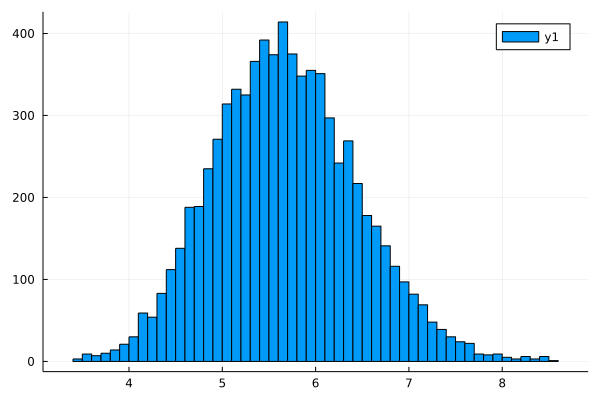

In [ ]:
histogram(vec(magnitudes))

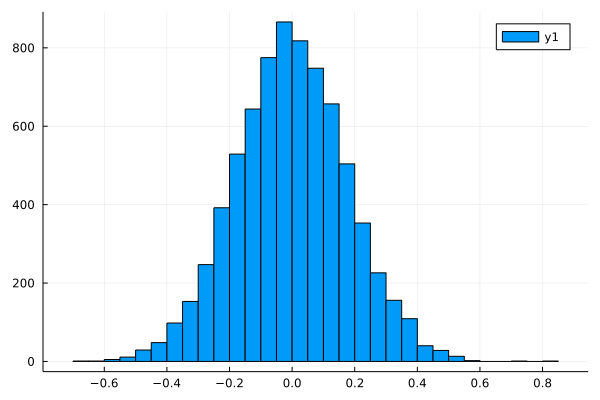

In [ ]:
histogram(vec(embedding_means))

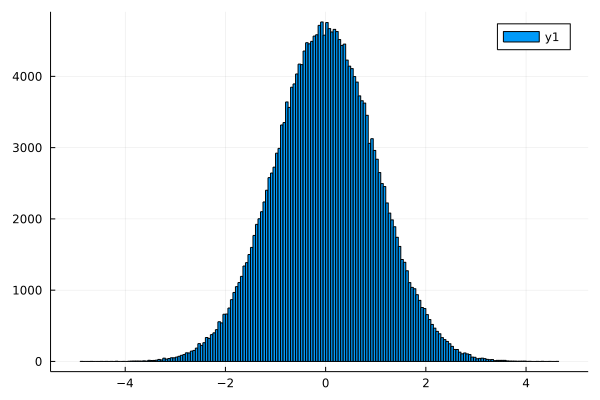

In [ ]:
histogram(reshape(model.embed.embedding, :, 1))

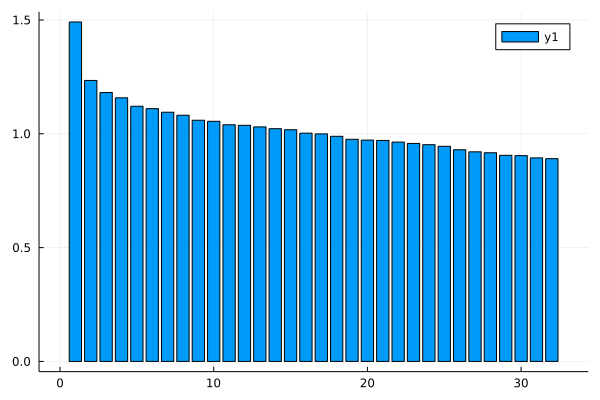

In [ ]:
pca = fit(PCA, model.embed.embedding; maxoutdim=32)
bar(principalvars(pca))

In [ ]:
pca = fit(PCA, model.embed.embedding; maxoutdim=2)

PCA(indim = 32, outdim = 2, principalratio = 0.08302979)

Pattern matrix (unstandardized loadings):
──────────────────────────
           PC1         PC2
──────────────────────────
1    0.209226    0.0259541
2   -0.325916    0.0345786
3   -0.228737    0.215029
4   -0.196273    0.0364265
5    0.266185   -0.134752
6    0.188163    0.198929
7    0.216199    0.103343
8   -0.272434    0.111666
9   -0.136066    0.170101
10   0.284771   -0.0140287
11  -0.147536    0.0055266
12   0.1951     -0.277944
13  -0.118782    0.146672
14  -0.0174249   0.118211
15  -0.114651   -0.307742
16   0.0616949   0.217589
17   0.136863   -0.420272
18   0.0996219  -0.0563684
19  -0.263224    0.0506219
20   0.231538    0.079638
21  -0.20547    -0.133918
22  -0.322259    0.117001
23   0.148469    0.289181
24   0.264884    0.112599
25   0.0505887   0.462331
26  -0.210417   -0.129981
27  -0.0141217  -0.11364
28   0.398637    0.255252
29   0.0940232  -0.0405534
30   0.343596   -0.0231967
31   0.317871    0.0471553
32  

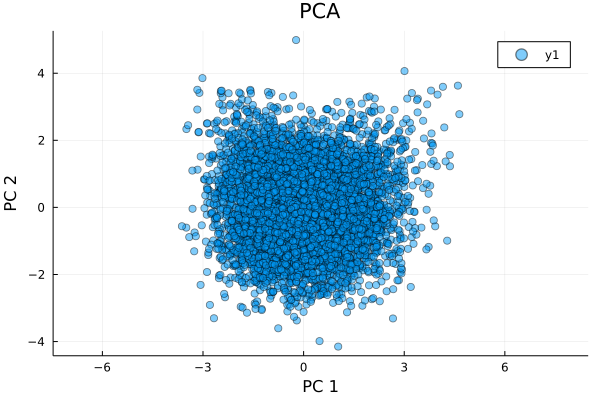

In [ ]:
Y_pca = predict(pca, model.embed.embedding)
scatter(Y_pca[1, :], Y_pca[2, :], alpha=0.5, aspectratio=:equal, title="PCA", xlabel="PC 1", ylabel="PC 2")

In [ ]:
function discretize_1d(X, res; dim=1)
    if size(X, 2) == 1
        return [[1]]
    end
    idxs_sorted = sortperm(X[dim, :])
    X = X[:, idxs_sorted]
    x_extrema = (X[dim, 1], X[dim, end])
    
    idxs = Vector{Vector{Int}}()
    idx = 1
    x_next = x_extrema[1] + res
    while x_next < x_extrema[2] + res
        idx_start = idx
        while (idx <= size(X, 2)) && (X[dim, idx] < x_next)
            idx += 1
        end  
        if (idx == idx_start)
        else
            push!(idxs, idxs_sorted[idx_start:(idx-1)])
        end
        x_next += res
    end
    idxs
end

function downsample_2d(X, res=0.5)
    idxs = Int[]
    total = 0
    for col in discretize_1d(X, res; dim=1)
        X_col = X[:, col]
        for row in discretize_1d(X_col, res; dim=2)
            idx = sample(row)
            push!(idxs, col[idx])
        end
    end
    idxs
end

downsample_2d (generic function with 2 methods)

240


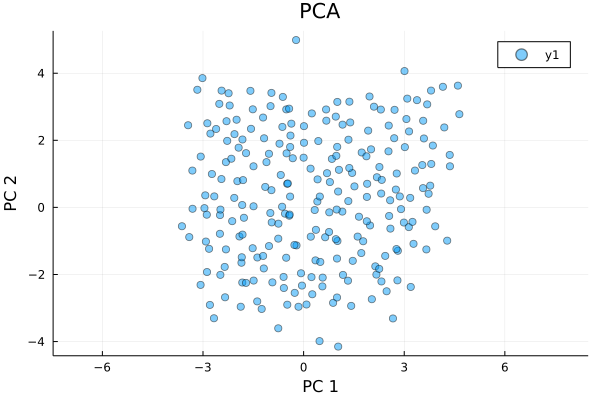

In [ ]:
idxs = downsample_2d(Y_pca, 0.45)
println(length(idxs))
scatter(Y_pca[1, idxs], Y_pca[2, idxs], alpha=0.5, aspectratio=:equal, title="PCA", xlabel="PC 1", ylabel="PC 2")

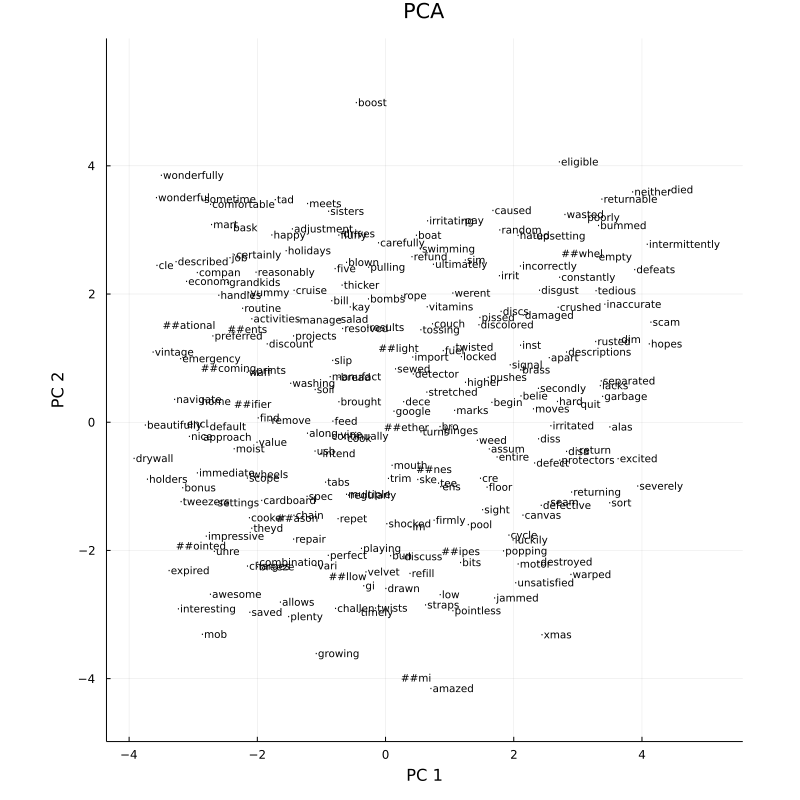

In [ ]:
annotations = [
    (Y_pca[1, idx], Y_pca[2, idx], (indexer.vocabulary[idx], 7, :centre)) for idx in idxs
]
plot(size=(800, 800))
annotate!(annotations)

scale = 1.2
x_min = scale * minimum(Y_pca[1, :])
x_max = scale * maximum(Y_pca[1, :])
y_min = scale * minimum(Y_pca[2, :])
y_max = scale * maximum(Y_pca[2, :])

plot!(xlims=(x_min, x_max), ylims=(y_min, y_max), 
    aspectratio=:equal, title="PCA", xlabel="PC 1", ylabel="PC 2"
)

In [ ]:
idxs = downsample_2d(Y_pca, 0.35)
length(idxs)

362

In [ ]:
X = model.embed.embedding[:, idxs[1:length(idxs)]]
Y_tsne = tsne(transpose(X), 2, 50, 1000, 20.0);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\sinai\.julia\packages\ProgressMeter\sN2xr\src\ProgressMeter.jl:618
Computing t-SNE 100%|████████████████████████████████████| Time: 0:00:03
  KL_divergence:  1.6475


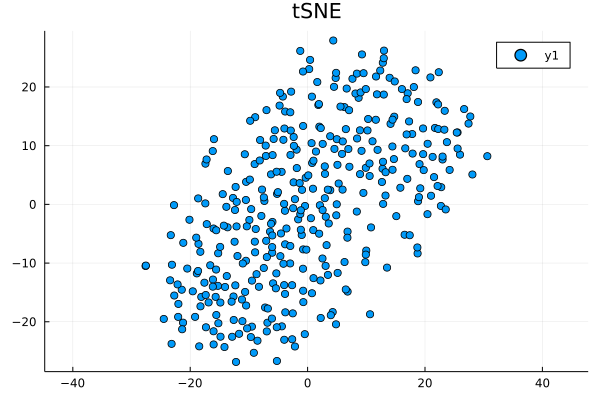

In [ ]:
scatter(Y_tsne[:, 1], Y_tsne[:, 2], aspectratio=:equal, title="tSNE")

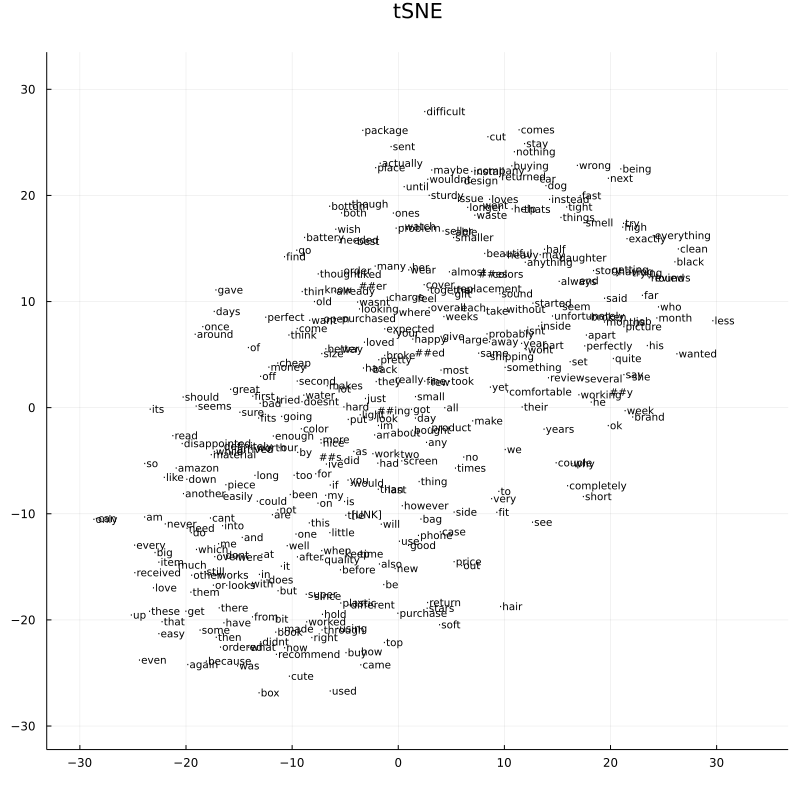

In [ ]:
annotations = [
    (Y_tsne[idx, 1], Y_tsne[idx, 2], Plots.text(indexer.vocabulary[idx], 7, :centre)) for idx in 1:length(idxs)
]
plot(size=(800, 800))
annotate!(annotations)

scale = 1.2
x_min = scale * minimum(Y_tsne[:, 1])
x_max = scale * maximum(Y_tsne[:, 1])
y_min = scale * minimum(Y_tsne[:, 2])
y_max = scale * maximum(Y_tsne[:, 2])

plot!(xlims=(x_min, x_max), ylims=(y_min, y_max), aspectratio=:equal, title="tSNE")

### multi-head attention

In [ ]:
model.encoder_layers[1].multihead_attention

MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
  denseQ = Dense(32 => 32),             # 1_056 parameters
  denseK = Dense(32 => 32),             # 1_056 parameters
  denseV = Dense(32 => 32),             # 1_056 parameters
  denseO = Dense(32 => 32),             # 1_056 parameters
)                  # Total: 8 arrays, 4_224 parameters, 16.945 KiB.

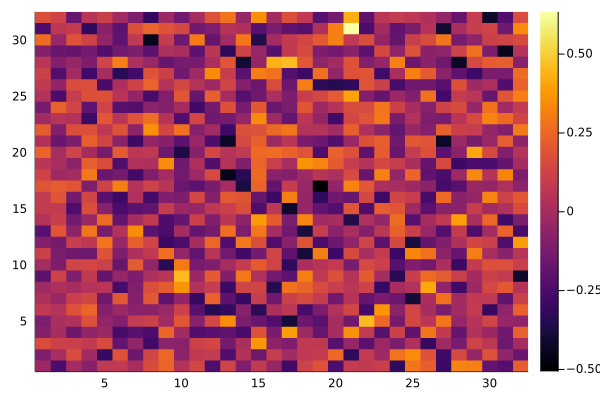

In [ ]:
heatmap(model.encoder_layers[1].multihead_attention.denseK.weight)

In [ ]:
model.encoder_layers[1]

TransformerEncoderBlock(
  MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
    denseQ = Dense(32 => 32),           # 1_056 parameters
    denseK = Dense(32 => 32),           # 1_056 parameters
    denseV = Dense(32 => 32),           # 1_056 parameters
    denseO = Dense(32 => 32),           # 1_056 parameters
  ),
  Dropout(0.1),
  LayerNorm(32),                        # 64 parameters
  Dense(32 => 128, relu),               # 4_224 parameters
  Dense(128 => 32),                     # 4_128 parameters
  Dropout(0.1),
  LayerNorm(32),                        # 64 parameters
)                  # Total: 16 arrays, 12_704 parameters, 50.727 KiB.

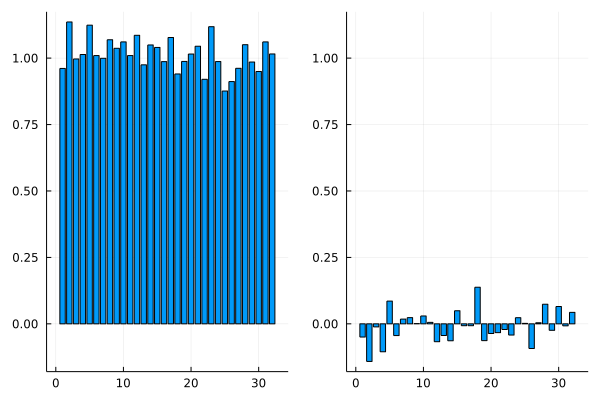

In [ ]:
p1 = bar(model.encoder_layers[1].layer_norm_attention.diag.scale, label="")
p2 = bar(model.encoder_layers[1].layer_norm_attention.diag.bias, label="")

plot(p1, p2, link=:y)

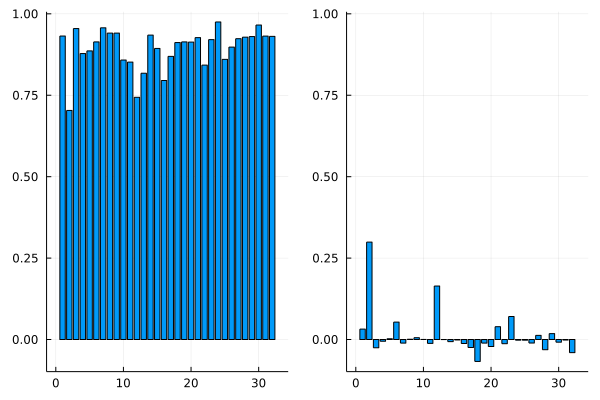

In [ ]:
p1 = bar(model.encoder_layers[1].layer_norm_feedforward.diag.scale, label="")
p2 = bar(model.encoder_layers[1].layer_norm_feedforward.diag.bias, label="")

plot(p1, p2, link=:y)

### Output layer

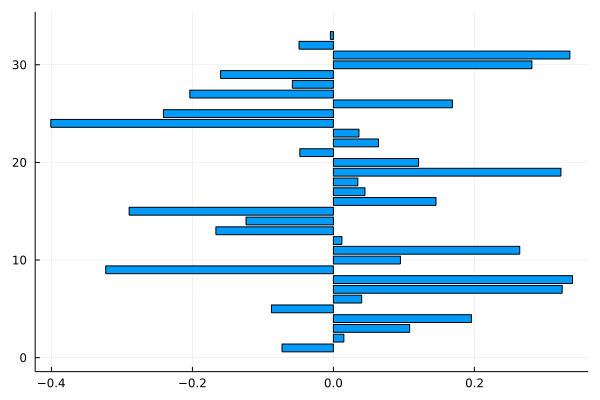

In [ ]:
 W = hcat(model.agg_layer.weight, model.agg_layer.bias)
bar(1:length(W), vec(W), orientation=:horizontal, label="")

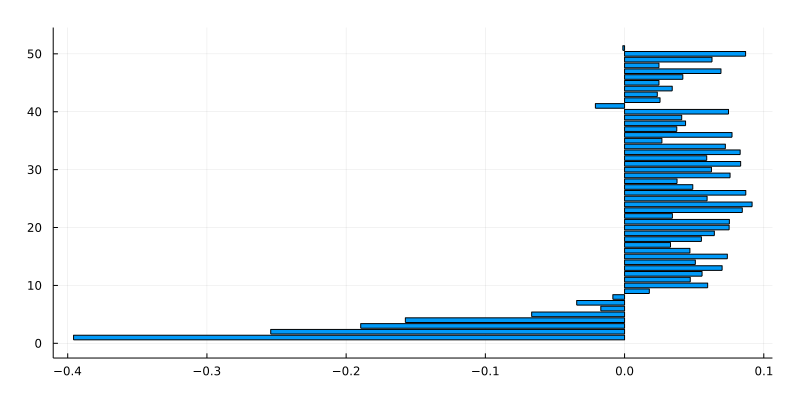

In [ ]:
n_out = size(model.classifier.weight, 1)
canvases = []
for i in 1:n_out
    W = vcat(model.classifier.weight[i, :], model.classifier.bias[i])
    p = bar(1:length(W), vec(W), orientation=:horizontal, label="")
    push!(canvases, p)
end
    
p =plot(canvases..., layout=(1, 5), link=:x, size=(800, 400), margin=5Plots.mm)